<a href="https://colab.research.google.com/github/IshaSarangi/Edureka_Notes/blob/main/Edureka_ABSA_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1QKo8Y7BrC4L8TBTvU3alImSUYe7jqZlk?usp=sharing#scrollTo=sNfl37vRRDJA

An E-commerce wants to go beyond the traditonal sentiment analysis (P/N) and wants to build a find grained sentiment analysis system that analyzes what customers really feel about the different aspects of products.

In [1]:
#Load dataset
import pandas as pd
df = pd.read_csv('/content/synthetic_absa_dataset.csv')
df.head()

,review,aspect,sentiment
0,The camera is terrible.,camera,negative
1,I'm disappointed with the price.,price,negative
2,The performance is neither good nor bad.,performance,neutral
3,Excellent design and worth the price.,design,positive
4,Nothing special about the screen.,screen,neutral


In [2]:
print(df['aspect'].value_counts())

aspect
performance    192
price          177
battery        173
screen         157
design         151
camera         150
Name: count, dtype: int64


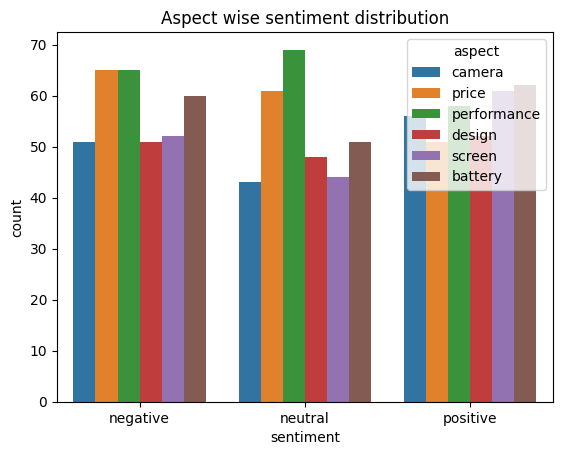

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df, hue='aspect')
plt.title("Aspect wise sentiment distribution")
plt.show()

In [4]:
#Prepare text pairs (Aspect: Sentiments) for the model's input
df['input_pair'] = df.apply(lambda x: f"What is the sentiment about the {x['aspect']} ? [SEP] {x['review']}", axis = 1)
df[['input_pair', 'sentiment']].head()

,input_pair,sentiment
0,What is the sentiment about the camera ? [SEP]...,negative
1,What is the sentiment about the price ? [SEP] ...,negative
2,What is the sentiment about the performance ? ...,neutral
3,What is the sentiment about the design ? [SEP]...,positive
4,What is the sentiment about the screen ? [SEP]...,neutral


In [5]:
#Encode sentiment labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
df[['input_pair', 'sentiment']].head()

,input_pair,sentiment
0,What is the sentiment about the camera ? [SEP]...,0
1,What is the sentiment about the price ? [SEP] ...,0
2,What is the sentiment about the performance ? ...,1
3,What is the sentiment about the design ? [SEP]...,2
4,What is the sentiment about the screen ? [SEP]...,1


In [6]:
#Split data for training and testing
from sklearn.model_selection import train_test_split
train_texts, test_texts, trainn_labels, test_labels = train_test_split(df['input_pair'], df['sentiment'], test_size = 0.2, random_state = 42)

In [7]:
#Using Huggingface Transformer: for encoding

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=64)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
print(train_encodings)

{'input_ids': [[101, 2054, 2003, 1996, 15792, 2055, 1996, 3976, 1029, 102, 3811, 8510, 2007, 1996, 3976, 1012, 102, 0, 0], [101, 2054, 2003, 1996, 15792, 2055, 1996, 2836, 1029, 102, 5409, 3325, 2007, 1996, 2836, 1012, 102, 0, 0], [101, 2054, 2003, 1996, 15792, 2055, 1996, 3976, 1029, 102, 5409, 3325, 2007, 1996, 3976, 1012, 102, 0, 0], [101, 2054, 2003, 1996, 15792, 2055, 1996, 3898, 1029, 102, 1996, 3898, 2003, 4445, 2204, 4496, 2919, 1012, 102], [101, 2054, 2003, 1996, 15792, 2055, 1996, 2640, 1029, 102, 3811, 8510, 2007, 1996, 2640, 1012, 102, 0, 0], [101, 2054, 2003, 1996, 15792, 2055, 1996, 2640, 1029, 102, 1045, 2293, 1996, 2640, 1997, 2023, 4031, 1012, 102], [101, 2054, 2003, 1996, 15792, 2055, 1996, 2640, 1029, 102, 1045, 2293, 1996, 2640, 1997, 2023, 4031, 1012, 102], [101, 2054, 2003, 1996, 15792, 2055, 1996, 4950, 1029, 102, 6581, 4950, 1998, 4276, 1996, 3976, 1012, 102, 0], [101, 2054, 2003, 1996, 15792, 2055, 1996, 3898, 1029, 102, 1996, 3898, 2003, 6659, 1012, 102, 0, 0,

In [9]:
#Class to create dataset in desired format

import torch

class ABSADataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = ABSADataset(train_encodings, trainn_labels.tolist())
test_dataset = ABSADataset(test_encodings, test_labels.tolist())

In [10]:
print(list(train_dataset))

[{'input_ids': tensor([  101,  2054,  2003,  1996, 15792,  2055,  1996,  3976,  1029,   102,
         3811,  8510,  2007,  1996,  3976,  1012,   102,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]), 'labels': tensor(2)}, {'input_ids': tensor([  101,  2054,  2003,  1996, 15792,  2055,  1996,  2836,  1029,   102,
         5409,  3325,  2007,  1996,  2836,  1012,   102,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]), 'labels': tensor(0)}, {'input_ids': tensor([  101,  2054,  2003,  1996, 15792,  2055,  1996,  3976,  1029,   102,
         5409,  3325,  2007,  1996,  3976,  1012,   102,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 

In [11]:
#Train BERT model with ABSA dataset

from transformers import BertForSequenceClassification, Trainer, TrainingArguments
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64,
    eval_strategy = 'epoch',
    logging_dir = './logs'
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ishasarangi (ishasarangi-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.010826
2,No log,0.002113
3,No log,0.001635


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=150, training_loss=0.10588553110758464, metrics={'train_runtime': 700.194, 'train_samples_per_second': 3.428, 'train_steps_per_second': 0.214, 'total_flos': 23433538766400.0, 'train_loss': 0.10588553110758464, 'epoch': 3.0})

In [13]:
#Predict the sentiments
def pred_aspect_sentiment(aspect, sentence):
    input_text = f"What is the sentiment about the {aspect} ? [SEP] {sentence}"
    inputs = tokenizer(input_text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return le.inverse_transform([pred])[0]

In [14]:
print(pred_aspect_sentiment("battery", 'The battery life is wonderful'))

positive


###Using Huggingface Transformer Pipeline

In [15]:
from transformers import pipeline
classifier = pipeline('text-classification', model='yangheng/deberta-v3-base-absa-v1.1')

#sample_text="The battery life is amazing, but the screen is poor"
sample_text="The battery life is ok, but the screen is poor"
#"The battery life is amazing, but the screen is poor[SEP]screen"  text pair
result_screen=classifier(sample_text,text_pair='screen')
result_battery=classifier(sample_text,text_pair='battery')

print(f"Aspect:screen sentiment:",result_screen)
print(f"Aspect:battery sentiment:",result_battery)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cpu


Aspect:screen sentiment: [{'label': 'Negative', 'score': 0.9960415363311768}]
Aspect:battery sentiment: [{'label': 'Positive', 'score': 0.8149920701980591}]


In [16]:
#Fine tuning HF model
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
model_name = "yangheng/deberta-v3-base-absa-v1.1"

#Load tokenizer and Tensorflow Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)

#Prepare input
sentence = "The battery life is amazing, but the screen is too dim."
aspect = "Battery Life"
inputs = tokenizer(f"{sentence} [SEP] {aspect}", return_tensors='tf')

#Predict
outputs = model(**inputs)
probs = tf.nn.softmax(outputs.logits, axis=1)
pred_class = tf.argmax(probs, axis=1).numpy()[0]

labels = ['Negative', 'Neutral', 'Positive']
print(f"Aspect: {aspect} | Sentiment: {labels[pred_class]} | Probabilities: {probs.numpy()[0]}")

pytorch_model.bin:   0%|          | 0.00/738M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDebertaV2ForSequenceClassification: ['deberta.embeddings.position_ids']
- This IS expected if you are initializing TFDebertaV2ForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDebertaV2ForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDebertaV2ForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you c

Aspect: Battery Life | Sentiment: Positive | Probabilities: [0.00162201 0.00114306 0.997235  ]
